In [2]:
import sys
import importlib
# Make imports work
sys.path.insert(0, '../')

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from mhealth_anomaly_detection import anomaly_detection
from mhealth_anomaly_detection import format_axis as fa
from mhealth_anomaly_detection import load_refs as lr
importlib.reload(anomaly_detection)

/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'mhealth_anomaly_detection.anomaly_detection' from '/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/anomaly_detection.py'>

In [4]:
# Load ad results
EXPERIMENTS = [
    'exp01',
    #'exp02',
    #'exp03'
]
N_SUBJECTS = 100
DAYS_OF_DATA = 90

results_list = []
for exp in EXPERIMENTS:
    fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
    fpath = Path('../cache', fname)
    res = pd.read_csv(fpath)
    res['experiment'] = exp
    results_list.append(res)
data_df = pd.concat(results_list).fillna(-1)

anomaly_detector_cols = [d for d in data_df.columns if d.endswith("_anomaly")]
groupby_cols = [
    'subject_id',
    'correlation_type',
    'window_size',
    'n_features',
    'anomaly_freq',
    'history_type',
    'experiment'
]

In [6]:
groupby_cols = [
    'subject_id',
    #'correlation_type',
    'window_size',
    'n_features',
    'anomaly_freq',
    'history_type',
    'experiment'
]

In [7]:
performance_df = anomaly_detection.performance_metrics(
    data=data_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)

print('Accuracy')
print(performance_df.groupby('model').accuracy.describe().round(3))
print('F1')
print(performance_df.groupby('model').accuracy.describe().round(3))
print('Sensitivity')
print(performance_df.groupby('model').sensitivity.describe().round(3))
print('Specificity')
print(performance_df.groupby('model').specificity.describe().round(3))

100%|██████████| 2400/2400 [00:09<00:00, 242.72it/s]


Accuracy
                  count   mean    std    min    25%    50%    75%    max
model                                                                   
IsolationForest  2400.0  0.711  0.144  0.389  0.578  0.756  0.822  0.956
NMF_003          2400.0  0.816  0.174  0.478  0.750  0.900  0.933  1.000
PCA_003          2400.0  0.823  0.176  0.489  0.761  0.911  0.944  1.000
RollingMean      2400.0  0.816  0.176  0.467  0.756  0.900  0.933  0.989
SVM_poly         2400.0  0.595  0.087  0.344  0.533  0.600  0.656  0.856
SVM_rbf          2400.0  0.746  0.156  0.367  0.611  0.800  0.867  0.967
SVM_sigmoid      2400.0  0.518  0.072  0.256  0.467  0.522  0.567  0.767
F1
                  count   mean    std    min    25%    50%    75%    max
model                                                                   
IsolationForest  2400.0  0.711  0.144  0.389  0.578  0.756  0.822  0.956
NMF_003          2400.0  0.816  0.174  0.478  0.750  0.900  0.933  1.000
PCA_003          2400.0  0.823  0.176  

In [8]:
performance_df.loc[performance_df.history_type == -1, 'history_type'] = 'history_all_28'
#performance_df.loc[performance_df.correlation_type == -1, 'corelation_type'] = 'Independent'

In [8]:

palette = lr.get_colors('../lib/colors.json')
model_order = [
    'RollingMean',
    'PCA_003',
    'NMF_003',
    'IsolationForest',
    'SVM_rbf',
    'SVM_poly',
    'SVM_sigmoid',
]
palette['model']

{'Linear Regression': '#718093',
 'Random Forest Regression': '#192a56',
 'Gradient Boosting Regression': '#487eb0',
 'Mixed Effects Random Forest': '#AF58BA',
 'Baseline': '#1A1A1A',
 'Logistic Regression': '#718093',
 'Random Forest Classifier': '#192a56',
 'Gradient Boosting Classifier': '#487eb0',
 'PCA': '#44AA99',
 'PCA_003': '#44AA99',
 'PCA_005': '#44AA99',
 'PCA_010': '#44AA99',
 'NMF': '#117733',
 'NMF_003': '#117733',
 'NMF_005': '#117733',
 'NMF_010': '#117733',
 'SVM': '#EE99AA',
 'SVM_rbf': '#EE99AA',
 'SVM_poly': '#994455',
 'SVM_sigmoid': '#882255',
 'IsolationForest': '#DDCC77',
 'RollingMean': '#88CCEE'}

<AxesSubplot: xlabel='metric', ylabel='Performance'>

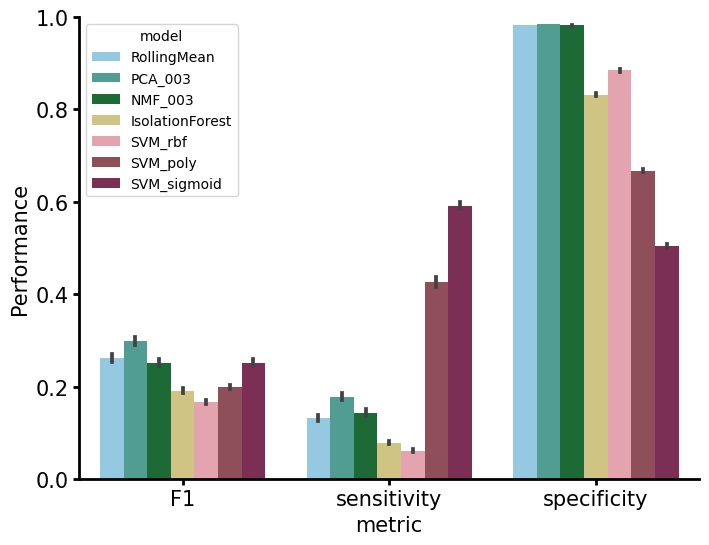

In [28]:
perf_melt = performance_df.melt(
    id_vars=groupby_cols + ['model'],
    value_vars=['F1', 'sensitivity', 'specificity'],
    var_name='metric',
    value_name='Performance'
)
perf_melt.loc[perf_melt.model == 'svm', 'model'] = 'SVM'
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(
    x='metric',
    y='Performance',
    hue='model',
    palette=palette['model'],
    hue_order=model_order,
    data=perf_melt,
    ax=ax
)
ax.set_ylim(0,1)
fa.despine_thicken_axes(ax, fontsize=15)

In [40]:
performance_df['anomaly_freq'].unique()

array([ 2,  7, 14, 28])

F1  sensitivity  specificity
model           history_type                                    
IsolationForest history_0_to_28  0.184        0.085        0.807
                history_all_28   0.199        0.073        0.857
NMF_003         history_0_to_28  0.245        0.140        0.982
                history_all_28   0.260        0.148        0.981
PCA_003         history_0_to_28  0.287        0.167        0.985
                history_all_28   0.310        0.190        0.985
RollingMean     history_0_to_28  0.261        0.133        0.984
                history_all_28   0.263        0.131        0.982
SVM_poly        history_0_to_28  0.204        0.416        0.691
                history_all_28   0.193        0.438        0.643
SVM_rbf         history_0_to_28  0.161        0.062        0.872
                history_all_28   0.173        0.061        0.897
SVM_sigmoid     history_0_to_28  0.246        0.584        0.491
                history_all_28   0.258        0.599        0.517

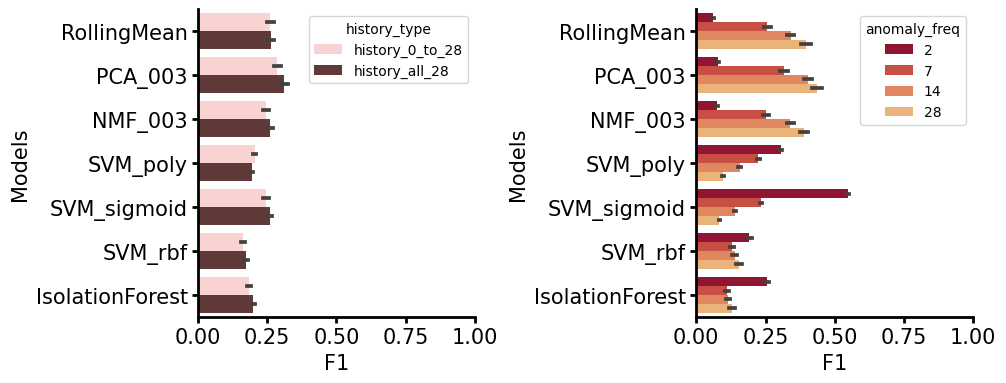

In [70]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
exp = 'exp01'
criteria = (
            (performance_df.experiment == exp)
)
palette['history_type'] = {
    'history_0_to_28': "#FFCCCC",
    'history_all_28': "#663333"
}
palette['anomaly_freq'] = {
    2: "#A50026",
    7: "#DD3D2D",
    14: "#F67E4B",
    28: "#FDB366"
}
metric = 'F1'
plt.subplots_adjust(wspace=.8)
for i, diff in enumerate(['history_type', 'anomaly_freq']):
    ax = axes[i]
    sns.barplot(
        y='model',
        x=metric,
        hue=diff,
        palette=palette[diff],
        data=performance_df[criteria],
        ax=ax
    )
    ax.set_xlim(0,1)
    #ax.legend().remove()
    ax.set_xlabel('F1')
    ax.set_ylabel('Models')
    fa.despine_thicken_axes(ax, fontsize=15)
performance_df[criteria].groupby(['model', 'history_type'])[['F1', 'sensitivity', 'specificity']].mean().round(3)

In [48]:
N_SUBJECTS = 100
DAYS_OF_DATA = 90

exp = 'exp02'
fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
fpath = Path('../cache', fname)
exp2_df = pd.read_csv(fpath)
exp2_df['experiment'] = exp

In [53]:
exp2_df['n_features'].unique()
anomaly_detector_cols = [d for d in exp2_df.columns if d.endswith("_anomaly")]
groupby_cols = [
    'subject_id',
    'window_size',
    'n_features',
    'anomaly_freq',
    'experiment'
]
performance2_df = anomaly_detection.performance_metrics(
    data=exp2_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)

100%|██████████| 6000/6000 [00:34<00:00, 176.39it/s]


In [54]:
performance2_df

,subject_id,window_size,n_features,anomaly_freq,experiment,model,true_positives,true_negatives,false_positives,false_negatives,sensitivity,precision,specificity,accuracy,F1
0,SID_0,7,5,2,exp02,RollingMean,0,45,1,44,0.000000,0.000000,0.978261,0.500000,NaN
1,SID_0,7,5,2,exp02,PCA_005,4,45,1,40,0.090909,0.800000,0.978261,0.544444,0.163265
2,SID_0,7,5,2,exp02,NMF_005,4,46,0,40,0.090909,1.000000,1.000000,0.555556,0.166667
3,SID_0,7,5,2,exp02,SVM_poly,8,25,21,36,0.181818,0.275862,0.543478,0.366667,0.219178
4,SID_0,7,5,2,exp02,SVM_sigmoid,28,22,24,16,0.636364,0.538462,0.478261,0.555556,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,SID_99,28,200,28,exp02,PCA_005,2,87,0,1,0.666667,1.000000,1.000000,0.988889,0.800000
35996,SID_99,28,200,28,exp02,NMF_005,0,86,1,3,0.000000,0.000000,0.988506,0.955556,NaN
35997,SID_99,28,200,28,exp02,SVM_poly,0,83,4,3,0.000000,0.000000,0.954023,0.922222,NaN
35998,SID_99,28,200,28,exp02,SVM_sigmoid,2,28,59,1,0.666667,0.032787,0.321839,0.333333,0.062500


/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


F1  sensitivity  specificity
model       n_features                                 
NMF_005     5           0.255        0.146        0.981
            10          0.287        0.174        0.984
            25          0.339        0.225        0.986
            100         0.415        0.313        0.989
            200         0.427        0.321        0.990
PCA_005     5           0.238        0.127        0.976
            10          0.392        0.282        0.990
            25          0.528        0.426        0.992
            100         0.607        0.489        0.991
            200         0.611        0.490        0.990
RollingMean 5           0.263        0.131        0.982
            10          0.298        0.160        0.984
            25          0.378        0.220        0.988
            100         0.530        0.354        0.990
            200         0.582        0.379        0.992
SVM_poly    5           0.188        0.429        0.659
            10          0.168        0.431        0.671
            25          0.178        0.426        0.701
            100         0.210        0.411        0.770
            200         0.229        0.405        0.799
SVM_rbf     5           0.173        0.061        0.897
            10          0.131        0.018        0.958
            25          0.084        0.004        0.991
            100         0.044        0.000        1.000
            200           NaN        0.000        1.000
SVM_sigmoid 5           0.258        0.599        0.517
            10          0.276        0.695        0.481
            25          0.289        0.786        0.427
            100         0.288        0.832        0.336
            200         0.282        0.836        0.293

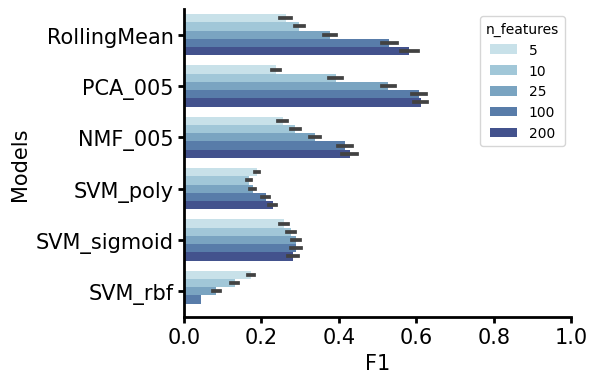

In [71]:
fig, ax = plt.subplots(figsize=(5,4))
palette['n_features'] = {
    5: "#C2E4EF",
    10: "#98CAE1",
    25: "#6EA6CD",
    100: "#4a7BB7",
    200: "#364B9A"
}
metric = 'F1'
diff = 'n_features'
sns.barplot(
    y='model',
    x=metric,
    hue=diff,
    palette=palette[diff],
    data=performance2_df,
    ax=ax
)
ax.set_xlim(0,1)
#ax.legend().remove()
ax.set_ylabel('Models')
ax.set_xlabel(metric.capitalize())
fa.despine_thicken_axes(ax, fontsize=15)
performance2_df.groupby(['model', diff])[['F1', 'sensitivity', 'specificity']].mean().round(3)

In [58]:
N_SUBJECTS = 100
DAYS_OF_DATA = 90

exp = 'exp03'
fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
fpath = Path('../cache', fname)
exp3_df = pd.read_csv(fpath)
exp3_df['experiment'] = exp


In [59]:
anomaly_detector_cols = [d for d in exp3_df.columns if d.endswith("_anomaly")]
groupby_cols = [
    'subject_id',
    'window_size',
    'correlation_type',
    'n_features',
    'anomaly_freq',
    'experiment'
]
performance3_df = anomaly_detection.performance_metrics(
    data=exp3_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)

100%|██████████| 3600/3600 [00:14<00:00, 246.97it/s]


In [60]:
performance3_df.correlation_type.unique()

array(['Independent', 'Linear', 'Non-linear'], dtype=object)

F1  sensitivity  specificity
model       correlation_type                                 
NMF_005     Independent       0.333        0.219        0.986
            Linear            0.286        0.172        0.985
            Non-linear        0.267        0.159        0.983
PCA_005     Independent       0.522        0.420        0.992
            Linear            0.370        0.262        0.988
            Non-linear        0.361        0.264        0.986
RollingMean Independent       0.378        0.216        0.988
            Linear            0.279        0.143        0.983
            Non-linear        0.289        0.195        0.980
SVM_poly    Independent       0.177        0.428        0.698
            Linear            0.172        0.393        0.700
            Non-linear        0.217        0.523        0.625
SVM_rbf     Independent       0.090        0.004        0.990
            Linear            0.146        0.026        0.948
            Non-linear        0.138        0.031        0.923
SVM_sigmoid Independent       0.289        0.783        0.430
            Linear            0.264        0.630        0.496
            Non-linear        0.263        0.672        0.467

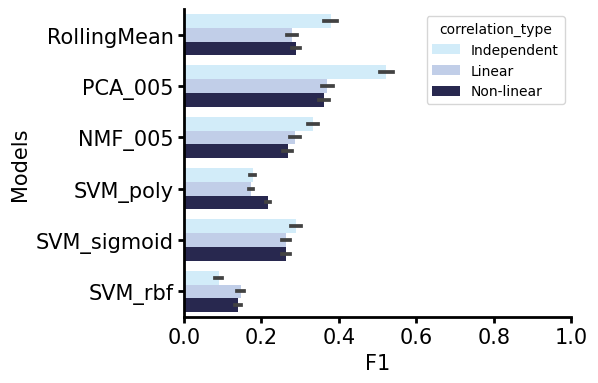

In [72]:
fig, ax = plt.subplots(figsize=(5,4))
palette['correlation_type'] = {
    'Independent': "#CCEEFF", 
    'Linear': "#BBCCEE", 
    'Non-linear': "#222255"
}
metric = 'F1'
diff = 'correlation_type'
sns.barplot(
    y='model',
    x=metric,
    hue=diff,
    palette=palette[diff],
    data=performance3_df,
    ax=ax
)
ax.set_xlim(0,1)
#ax.legend().remove()
ax.set_ylabel('Models')
ax.set_xlabel(metric.capitalize())
fa.despine_thicken_axes(ax, fontsize=15)
performance3_df.groupby(['model', diff])[['F1', 'sensitivity', 'specificity']].mean().round(3)

In [4]:
N_SUBJECTS = 100
DAYS_OF_DATA = 90

exp = 'exp07'
fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
fpath = Path('../cache', fname)
exp7_df = pd.read_csv(fpath)
exp7_df['experiment'] = exp


In [6]:

groupby_cols = [
    'subject_id',
    #'correlation_type',
    'window_size',
    'n_features',
    'anomaly_freq',
    'history_type',
    'experiment'
]
anomaly_detector_cols = [d for d in exp7_df.columns if d.endswith("_anomaly")]
performance7_df = anomaly_detection.performance_metrics(
    data=exp7_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)


100%|██████████| 600/600 [00:02<00:00, 260.40it/s]


/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZ

F1  sensitivity  specificity
model       n_features                                 
NMF_005     5           0.336        0.303        0.964
            10          0.287        0.070        0.962
            25          0.315        0.057        0.964
            50          0.314        0.053        0.969
            100         0.337        0.043        0.973
            500         0.331        0.057        0.971
PCA_005     5           0.356        0.247        0.964
            10          0.319        0.063        0.959
            25          0.351        0.047        0.971
            50          0.308        0.047        0.966
            100         0.313        0.053        0.965
            500         0.271        0.070        0.955
RollingMean 5           0.416        0.300        0.969
            10          0.330        0.063        0.963
            25          0.301        0.033        0.970
            50          0.332        0.033        0.972
            100         0.336        0.027        0.976
            500         0.378        0.047        0.979
SVM_poly    5           0.109        0.710        0.598
            10          0.086        0.537        0.571
            25          0.087        0.587        0.556
            50          0.082        0.523        0.568
            100         0.088        0.543        0.576
            500         0.080        0.590        0.528
SVM_rbf     5           0.202        0.030        0.915
            10          0.197        0.137        0.908
            25          0.475        0.013        0.996
            50            NaN        0.000        0.999
            100           NaN        0.000        0.999
            500         0.500        0.003        0.999
SVM_sigmoid 5           0.094        0.750        0.508
            10          0.079        0.607        0.499
            25          0.074        0.750        0.358
            50          0.078        0.897        0.271
            100         0.075        0.937        0.211
            500         0.076        0.983        0.176

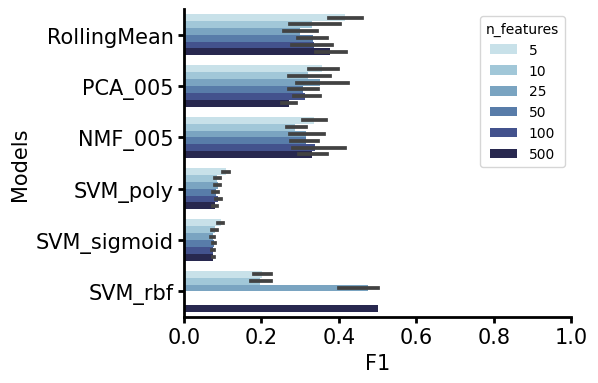

In [11]:

fig, ax = plt.subplots(figsize=(5,4))
palette['n_features'] = {
    5: "#C2E4EF",
    10: "#98CAE1",
    25: "#6EA6CD",
    50: "#4a7BB7",
    100: "#364B9A",
    500: "#222255",
}
metric = 'F1'
diff = 'n_features'
sns.barplot(
    y='model',
    x=metric,
    hue=diff,
    palette=palette[diff],
    data=performance7_df,
    ax=ax
)
ax.set_xlim(0,1)
#ax.legend().remove()
ax.set_ylabel('Models')
ax.set_xlabel(metric.capitalize())
fa.despine_thicken_axes(ax, fontsize=15)
performance7_df.groupby(['model', diff])[['F1', 'sensitivity', 'specificity']].mean().round(3)